# Experimenting with pixel level classification of snow
Here we are using the Copernicus Scene Classification Label (SCL) as ground truth (GT).  To what extent can we reverse engineer the algoritmically defined SCL with simple machine learning?

In [1]:
import numpy as np
import pathlib
import glob
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4    # Could be imported lazily, but best to be explicit, fail early if not installed

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
# Band meanings
bandMeanings = {
    0: "Coastal Aerosol",
    1: "Blue",
    2: "Green",
    3: "Red",
    4: "Vegetation Red Edge 1",
    5: "Vegetation Red Edge 2",
    6: "Vegetation Red Edge 3",
    7: "Near-Infrared",
    8: "Narrow Near-Infrared",
    9: "Water Vapor",
    10: "Cirrus",
    11: "Shortwave Infrared 1",
    12: "Shortwave Infrared 2"
}

# In the xarray dataset, all bands are now named
# Define here the band names which we want to use as features
# Just print(ds) to see the band names in the dataset, which is loaded a bit lower down

feature_bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B10",
    "B11",
    "B12",
    "Elevation",  # Easy to add or remove new features now like elevation
    "Gradient_lon",
    "Gradient_lat",
]

In [3]:
# Lets build a pattern vector , n by m, where n=total number of pixels and m=13, form the L1C data
# Simultaneously read the snow GT from the L2A data

# New data load code here
# New data available at https://drive.google.com/drive/folders/1rVl_WCC8GxNiKkr_Sa2N8Oac0kMQWU_Y?usp=drive_link
# We have a single .nc file for each patch, for each year

base_path = '../data_murray_x'  # Replace with path for folder with all the .nc files

def get_data_list():
    # Get a list of all the .nc files in the base_path directory.
    glob_string = base_path + r'/*.nc'
    data_list = sorted(list(glob.glob(glob_string)))
    
    return data_list

def test_get_data_list():
    data_list = get_data_list()
    print(f"There are {len(data_list)} files")  # Should give 11 patches x 6 years = 66 files
    print("Reading the first item:")
    print(xr.open_dataset(data_list[0]))
test_get_data_list()
    

There are 66 files
Reading the first item:
<xarray.Dataset>
Dimensions:       (t: 59, x: 146, y: 155)
Coordinates:
    lon           (x, y) float64 ...
    lat           (x, y) float64 ...
    date          (t) datetime64[ns] ...
Dimensions without coordinates: t, x, y
Data variables: (12/19)
    B01           (t, x, y) int16 ...
    B02           (t, x, y) int16 ...
    B03           (t, x, y) int16 ...
    B04           (t, x, y) int16 ...
    B05           (t, x, y) int16 ...
    B06           (t, x, y) int16 ...
    ...            ...
    SCL           (t, x, y) int16 ...
    SNW           (t, x, y) int16 ...
    CLD           (t, x, y) int16 ...
    Elevation     (x, y) float32 ...
    Gradient_lon  (x, y) float32 ...
    Gradient_lat  (x, y) float32 ...
Attributes:
    description:  Sentinel L1C, L2A, and DEM data
    patchname:    An_Riabhachan


In [4]:
def build_feats_and_gt_lists(data_list, max_cloud_cover_pc=50, sample_rate=0.01):
    # Return a tuple of corresponding lists:
    # 1: list of file paths of l1c (13 band) data
    # 2: list dataframes, each with one row per-pixel, columns for features (13) + 3 GT related columns
    path_list = []
    df_list = []
    for filename in data_list:
        ds = xr.open_dataset(filename)

        # New procedure to drop dates with cloud cover over threshold
        grouped_by_date = ds["CLD"].groupby('date')
        average_cld_by_date = grouped_by_date.mean(dim=["x", "y"])
        dates_above_threshold = average_cld_by_date > max_cloud_cover_pc
        ds = ds.sel(t =~ dates_above_threshold)
        
        ds_features = ds[feature_bands]
        imStack = ds_features.to_array().values

        nb, nt, nx, ny = imStack.shape
        assert nb == 16

        featsOneIm = imStack.reshape(nb, nt * nx * ny)
        df = pd.DataFrame(featsOneIm.T, columns=feature_bands)

        # Load the GT bands
        gtIm = ds[["SCL", "SNW", "CLD"]].to_array().values
        assert gtIm.shape[1:] == imStack.shape[1:]
        
        df['SCL'] = gtIm[0, :, :, :].flatten()
        df['SnowProb'] = gtIm[1, :, :,:].flatten()   
        df['CloudProb'] = gtIm[2, ...].flatten()

        # Add column with patch name
        df["patchname"] = ds.attrs["patchname"]

        # Randomly take a subset of the remaining pixels to reduce size of dataset
        df = df.sample(frac=sample_rate)

        path_list += [filename]
        df_list += [df]
    return path_list, df_list

def test_build_feats_and_gt_lists():
    short_data_list = get_data_list()[:5]   # just take a few files for speed in test
    
    max_cc = 100
    path_list_1, df_list_1 = build_feats_and_gt_lists(short_data_list, max_cloud_cover_pc=max_cc, sample_rate=0.001)
    concat_df_1 = pd.concat(df_list_1)
    print(f"\nFound {len(concat_df_1)} valid pixels with snow_cover <= {max_cc}")
    assert len(path_list_1) == len(df_list_1)
    
    max_cc = 1
    path_list_2, df_list_2 = build_feats_and_gt_lists(short_data_list, max_cloud_cover_pc=max_cc, sample_rate=0.001)
    concat_df_2 = pd.concat(df_list_2)
    print(f"\nFound {len(concat_df_2)} valid pixels with snow_cover < {max_cc}") 
    assert len(concat_df_1) > len(concat_df_2)   # Ensure max_cloud_cover_pc has an effect
    
    print(path_list_2[0])
    print(df_list_2[0].describe())
    
test_build_feats_and_gt_lists()


Found 6833 valid pixels with snow_cover <= 100

Found 702 valid pixels with snow_cover < 1
../data_murray_x/An_Riabhachan_2018.nc
               B01          B02          B03          B04          B05  \
count   136.000000   136.000000   136.000000   136.000000   136.000000   
mean   2388.919189  2179.558838  2025.132324  2031.875000  2349.507324   
std    2030.001343  2071.854004  1928.080322  2090.387939  1942.964600   
min    1058.000000   704.000000   438.000000   264.000000   318.000000   
25%    1207.000000   962.500000   890.250000   771.250000  1166.750000   
50%    1341.500000  1061.500000  1041.500000   962.000000  1379.000000   
75%    1607.000000  1514.750000  1438.750000  1491.250000  2062.750000   
max    6426.000000  6147.000000  6418.000000  6257.000000  6110.000000   

               B06          B07          B08          B8A          B09  \
count   136.000000   136.000000   136.000000   136.000000   136.000000   
mean   3018.617676  3321.757324  3294.242676  3638.014

### Meanings of SCL codes

0 - No data
1 - Saturated / Defective
2 - Dark Area Pixels
3 - Cloud Shadows
4 - Vegetation
5 - Bare Soils
6 - Water
7 - Clouds low probability / Unclassified
8 - Clouds medium probability
9 - Clouds high probability
10 - Cirrus
11 - Snow / Ice

Total #pixels: 1290, class counts: Counter({False: 1188, True: 102})


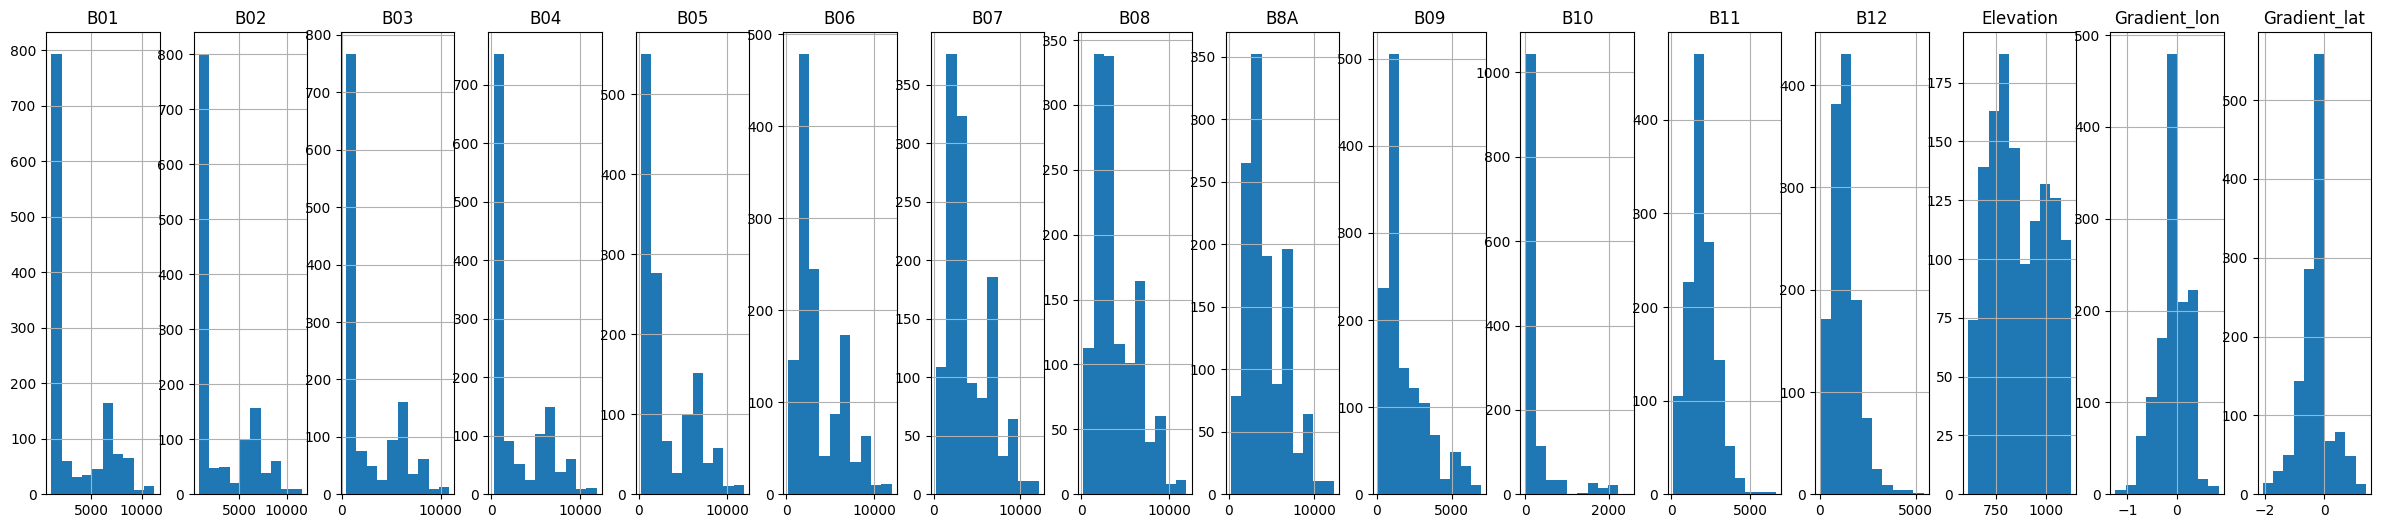

In [5]:
def build_total_df_and_gt(df_list):
    # Return a tuple:
    # X_df: a concatonated dataframe containing band information only, and 
    # y: a concatenated GT array
    # Thus X_df, y are ready to be fed to sklearn
    
    df_list_feats_only = [df.iloc[:, :16] for df in df_list]
    gt_list = [np.array(df['SCL']) for df in df_list]
    
    X_df = pd.concat(df_list_feats_only)
    y = np.hstack(gt_list)
    y = (y==11)   # 11 is "Snow"
    return X_df, y
    
def test_build_total_df_and_gt():
    short_data_list = get_data_list()[:5]   # just take a few files for speed in test
    path_list, df_list = build_feats_and_gt_lists(short_data_list, max_cloud_cover_pc=20, sample_rate=0.001)
    X_df, y = build_total_df_and_gt(df_list)
    print(f"Total #pixels: {len(X_df)}, class counts: {Counter(y)}")
    fig, axis = plt.subplots(1, 16, figsize=(30,6))
    X_df.hist(ax=axis)
    plt.show()
    assert len(X_df) == len(y)
    
test_build_total_df_and_gt()
    


## Main program
* Split train/test robustly on a patch basis
* Train a classifier
* Evaluate AUC
* Display some image results

In [6]:
# Get a list of all the available top-level patch names
patch_names = list(set(xr.open_dataset(f).attrs["patchname"] for f in get_data_list()))
patch_names

['Coire_Domhain',
 'Aonach_Beag',
 'Creag_Meagaidh',
 'An_Riabhachan',
 'Ciste_Mhearad',
 'Coire_Cruach_Sneachda',
 'An_Stuc',
 'Carn_na_Caim',
 'Gael_Charn',
 'Beinn_a_Bhuird',
 'Beinn_Mhanach']

In [7]:
# Assign patches roughly 2/3 : 1/3  train:test
cut_i = int(len(patch_names) * (2/3))
train_patches = patch_names[:cut_i]
test_patches = patch_names[cut_i:]
assert len(train_patches + test_patches) == len(patch_names)
train_patches, test_patches

(['Coire_Domhain',
  'Aonach_Beag',
  'Creag_Meagaidh',
  'An_Riabhachan',
  'Ciste_Mhearad',
  'Coire_Cruach_Sneachda',
  'An_Stuc'],
 ['Carn_na_Caim', 'Gael_Charn', 'Beinn_a_Bhuird', 'Beinn_Mhanach'])

In [8]:
def matches_list(p, patch_list):
    return any([pl in p for pl in patch_list])
    
def test_matches_list():
    patch_list = ['An_Stuc', 'Beinn_a_Bhuird']
    assert matches_list ('blah/An_Stuc/blah2234', patch_list)
    assert not matches_list('blah/Alps/blah564', patch_list)
test_matches_list()

In [9]:
path_list, df_list = build_feats_and_gt_lists(get_data_list(), max_cloud_cover_pc=50, sample_rate=0.005)

train_path_list, train_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, train_patches)]))
test_path_list, test_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, test_patches)]))
assert len(train_df_list) + len(test_df_list) == len(df_list)
print(len(train_df_list), len(test_df_list), len(df_list))

42 24 66


In [10]:
X_train, y_train = build_total_df_and_gt(train_df_list)
X_test, y_test = build_total_df_and_gt(test_df_list)

print(len(X_train), len(X_test))

84902 48003


In [11]:
# Setup a sklearn Pipeline
pipe = Pipeline([
    ("Scaling", StandardScaler()),
    #("Classifier", QuadraticDiscriminantAnalysis())
    ("Classifier", RandomForestClassifier())
])

cls = pipe.fit(np.array(X_train), y_train)

In [12]:
auc = roc_auc_score(y_test, cls.predict_proba(np.array(X_test))[:,1])
print(f"AUC = {auc:.3f}")

AUC = 0.963


In [13]:
confusion_matrix(y_test, cls.predict(np.array(X_test)))

array([[44935,   709],
       [ 1425,   934]])

In [14]:
def RGBfromStack13(imStack):
    rgbIm = np.dstack((imStack[3, :,:], imStack[2, :,:], imStack[1, :,:]))
    rgbIm = 1.5 * rgbIm / 10000
    rgbIm = rgbIm.clip(0, 1)
    return rgbIm

In [ ]:
for p1 in test_path_list[:1]:
    ds = xr.open_dataset(p1)

    for t in ds.t:
    
        ds_features = ds[feature_bands]
        imStack = ds_features.sel(t=t).to_array().values
    
        nb, nx, ny = imStack.shape
        featsOneIm = imStack.reshape(nb, -1)
        classified_image = cls.predict_proba(featsOneIm.T)[:,1]
        classified_image = classified_image.reshape(nx, ny)
    
        # Get the corresponding GT image.  This has 3 channels, we need the 1st, value 11 means snow.
        imGT = ds["SCL"].sel(t=t).values == 11
        
        # Now display three images:  RGB image, probability image, GT image
        fig = plt.figure(figsize=(8, 3))
        fig.suptitle(f"{ds.attrs['patchname']}: {t.date.values}")
        plt.subplot(1,3,1)
        plt.imshow(RGBfromStack13(imStack), interpolation='nearest')
        plt.title("RGB")
        plt.subplot(1,3,2)
        plt.imshow(classified_image, vmin=0, vmax=1)
        plt.title("Prob. image")
        plt.subplot(1,3,3)
        plt.imshow(imGT)
        plt.title("GT")
        plt.show()